In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import scanpy as sc
import scipy as sp
import anndata as ad
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
in_dir = '../../results/08_mouse_ssc/01_integrate_data'
out_dir = '../../results/08_mouse_ssc/02_clustering'
os.makedirs(out_dir, exist_ok=True)

In [3]:
adata = sc.read_h5ad(f'{in_dir}/adata.h5ad')
sc.pp.filter_genes(adata, inplace=True, min_cells=50)

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

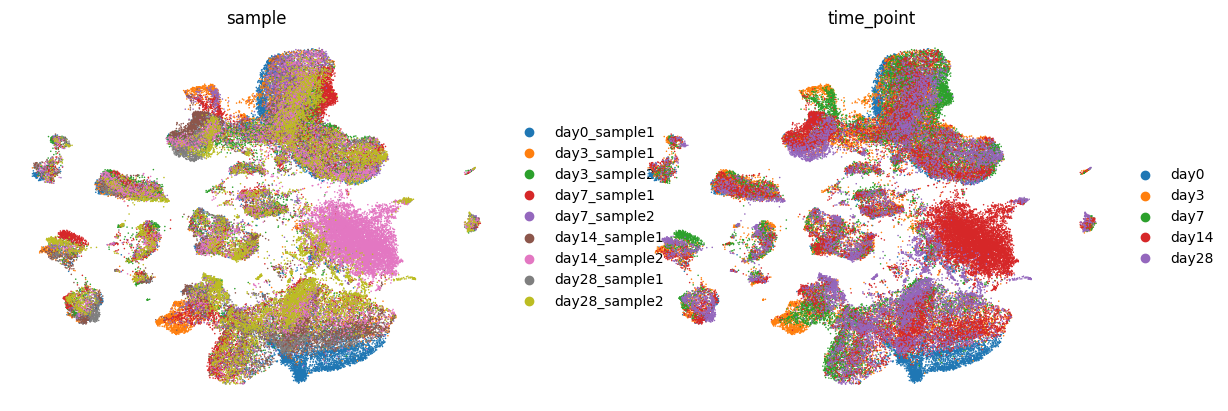

In [5]:
sc.pl.umap(adata, color=["sample", "time_point"], size=5, frameon=False)

In [7]:
sc.tl.leiden(adata, key_added="leiden", 
             resolution=0.5, random_state=0, n_iterations=2, flavor="igraph")

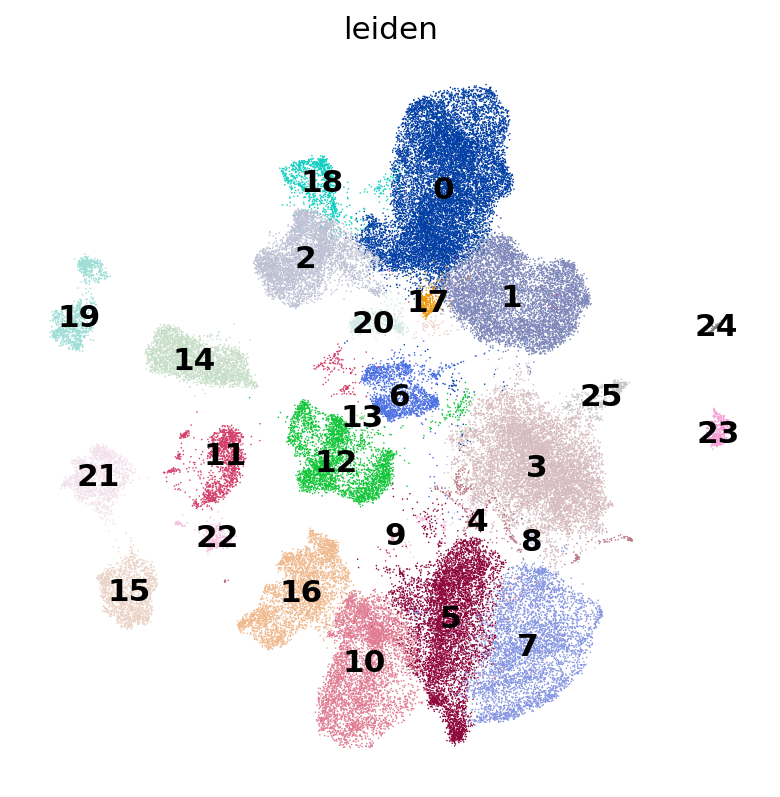

In [8]:
sc.set_figure_params(figsize=(6, 6))

sc.pl.umap(adata, color=["leiden"], size=2, frameon=False, legend_loc='on data')

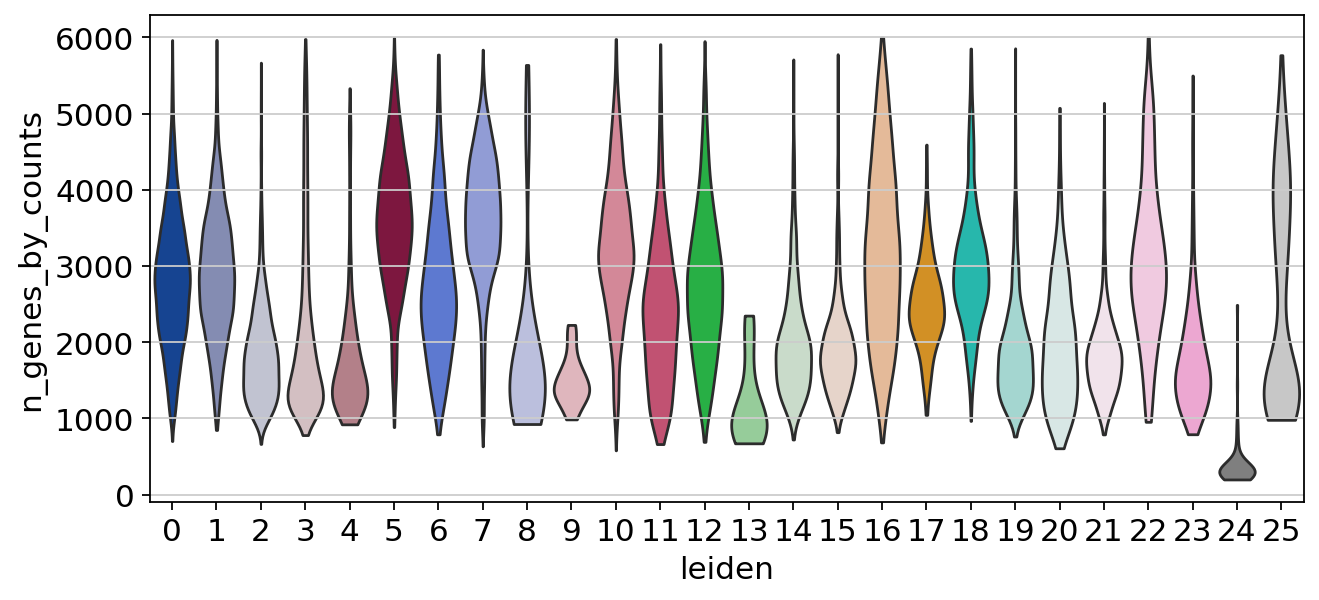

In [9]:
sc.set_figure_params(figsize=(8, 4))

sc.pl.violin(adata, ['n_genes_by_counts'],
             jitter=0.4, multi_panel=True, groupby='leiden', size=0)

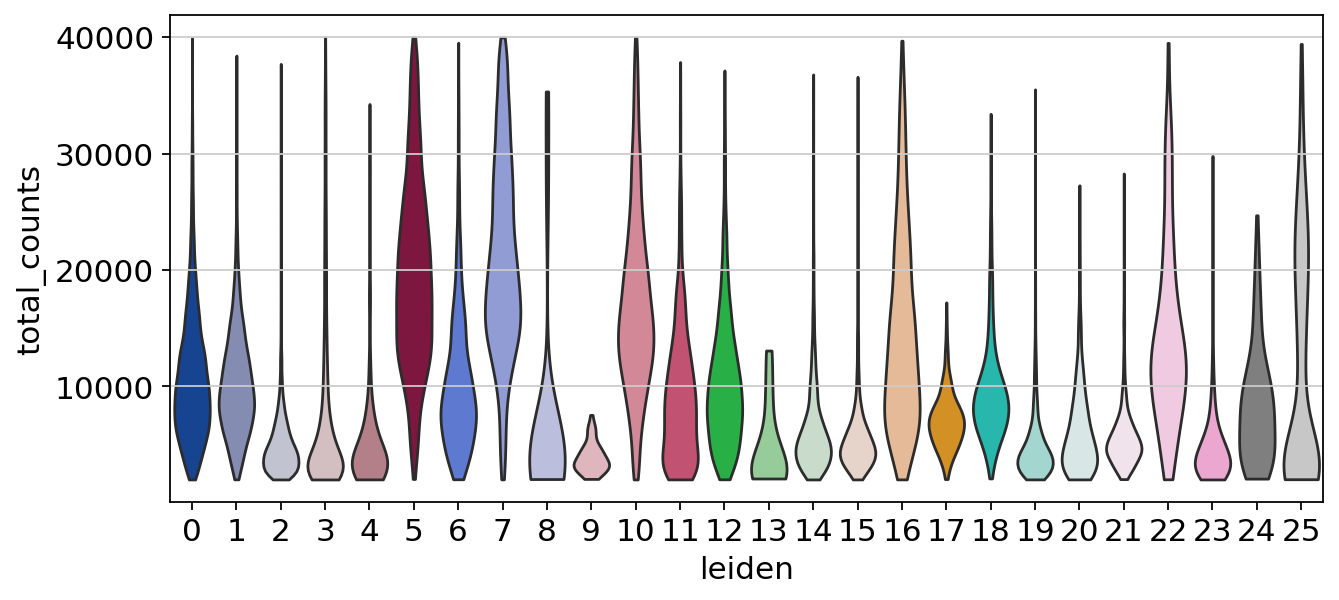

In [10]:
sc.pl.violin(adata, ['total_counts'],
             jitter=0.4, multi_panel=True, groupby='leiden', size=0)

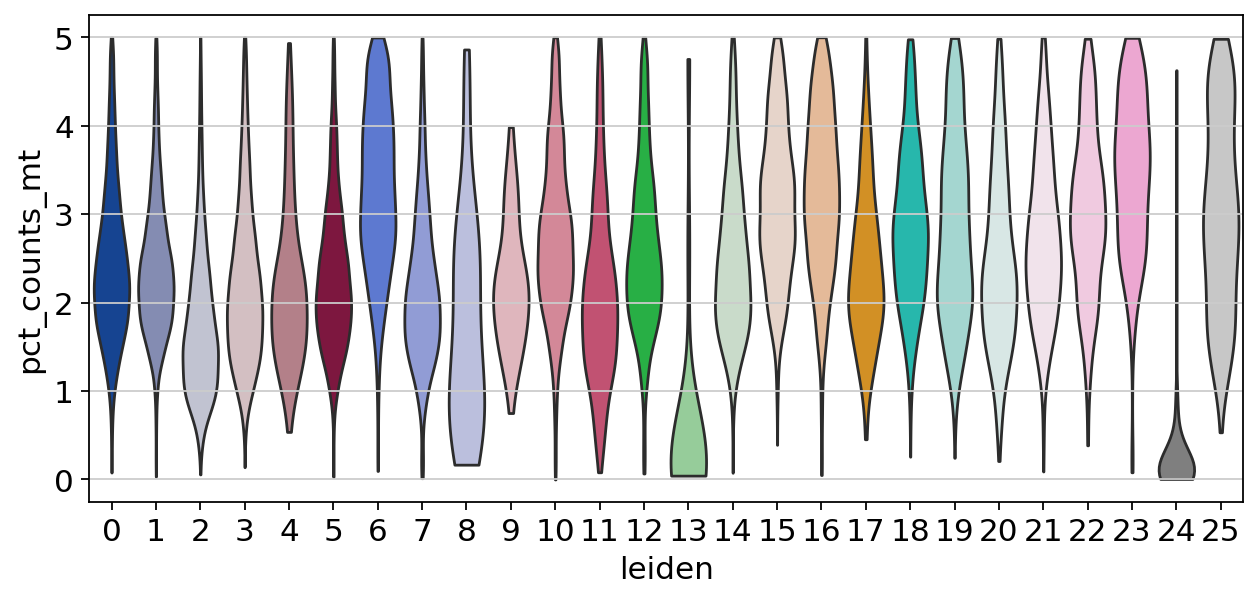

In [11]:
sc.pl.violin(adata, ['pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='leiden', size=0)

In [12]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False)

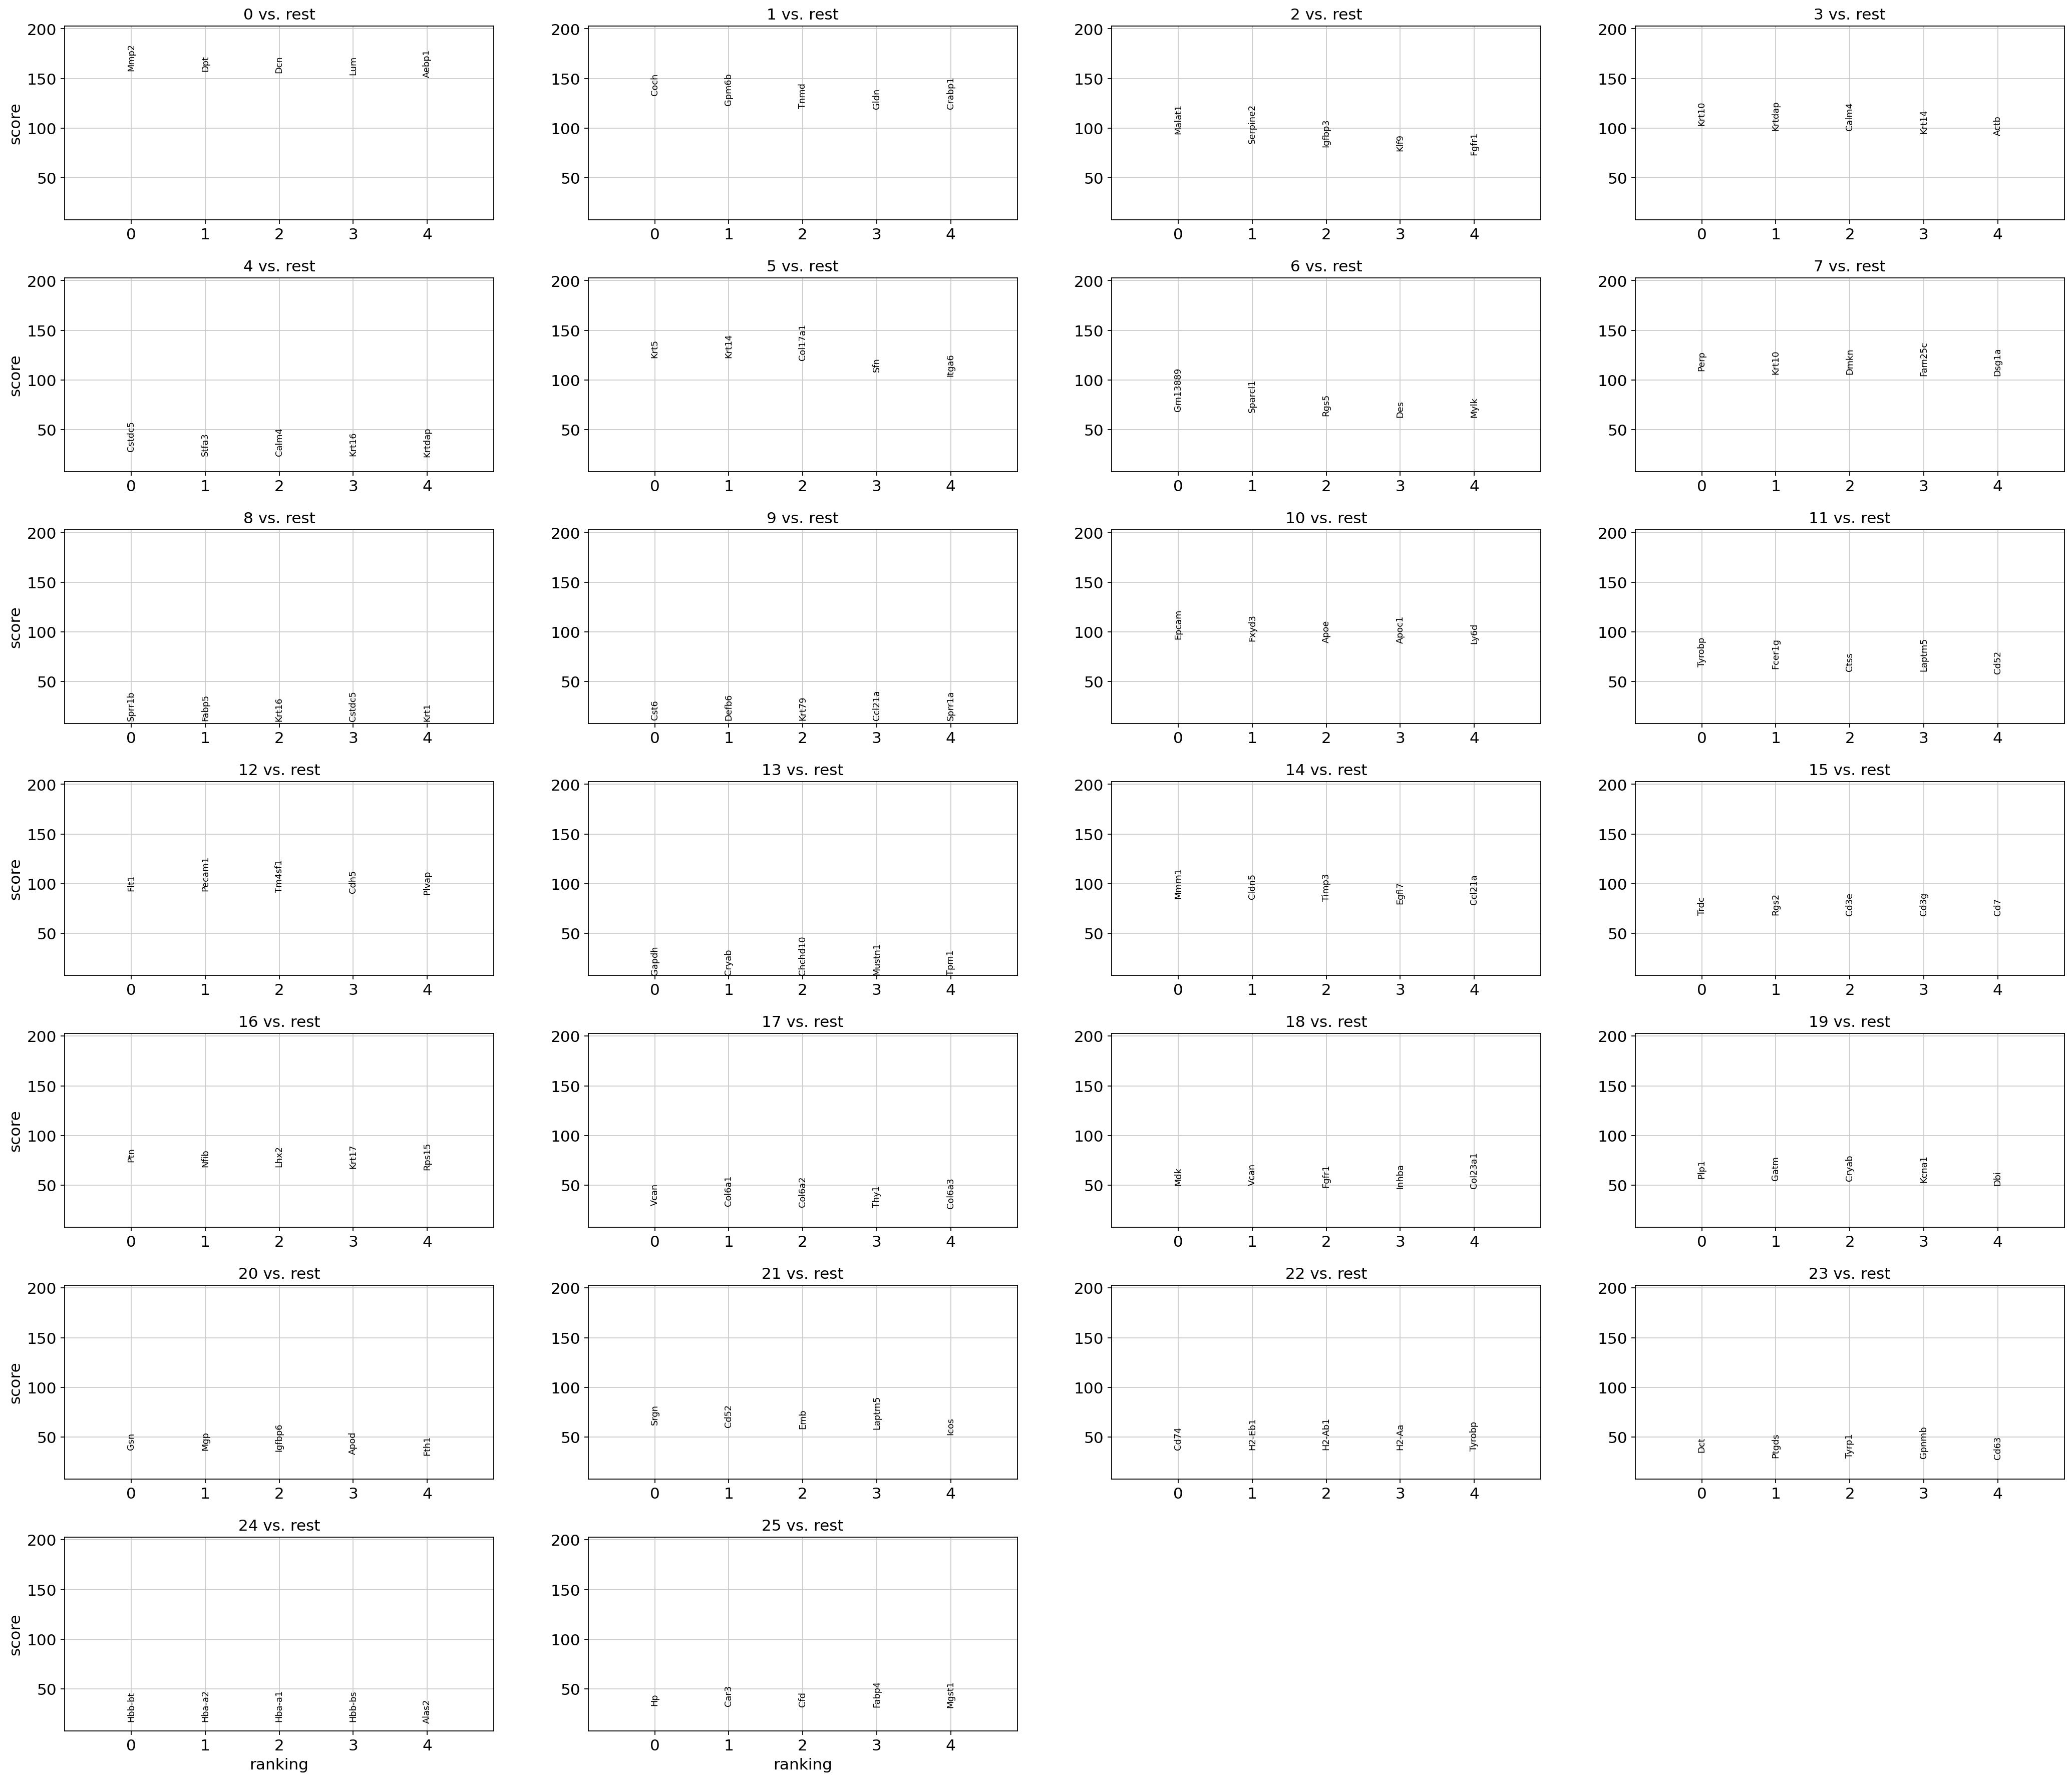

In [13]:
sc.pl.rank_genes_groups(adata, n_genes=5)

In [14]:
df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)

# Extract marker genes, log fold changes, and p-values
results = []
for cluster in adata.uns['rank_genes_groups']['names'].dtype.names:
    cluster_marker_genes = adata.uns['rank_genes_groups']['names'][cluster]
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges'][cluster]
    pvals = adata.uns['rank_genes_groups']['pvals'][cluster]
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj'][cluster]
    
    for gene, logfc, pval, pval_adj in zip(cluster_marker_genes, logfoldchanges, pvals, pvals_adj):
        results.append({
            'gene': gene,
            'log fold change': logfc,
            'p-value': pval,
            'adjusted p-value': pval_adj,
            'cluster': cluster
        })
        
# Convert to DataFrame
markers_df = pd.DataFrame(results)

In [15]:
markers_df.head()

,gene,log fold change,p-value,adjusted p-value,cluster
0,Mmp2,3.611226,0.0,0.0,0
1,Dpt,4.249794,0.0,0.0,0
2,Dcn,4.633496,0.0,0.0,0
3,Lum,4.117812,0.0,0.0,0
4,Aebp1,3.869494,0.0,0.0,0


In [16]:
#df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)
markers_df.to_csv(f'{out_dir}/top_200_markers.csv', index=False)

In [17]:
adata.write_h5ad(f'{out_dir}/adata.h5ad')